In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from hydra import compose, initialize
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchdiffeq

from UniversalUnconsciousness.plot_utils import load_font

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

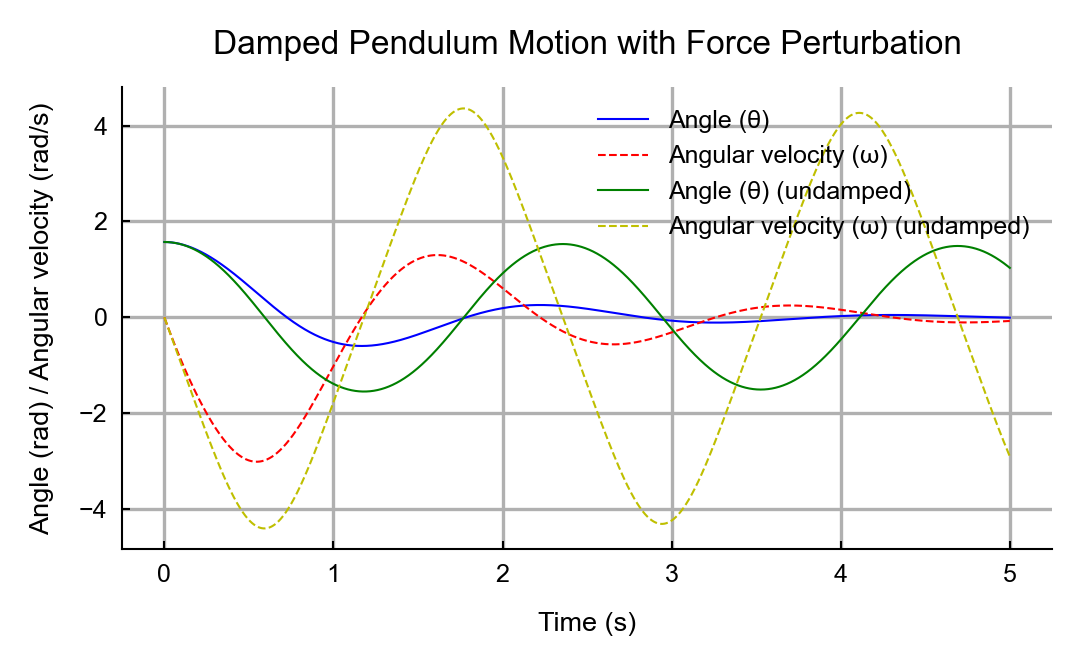

In [5]:


# Physical parameters
L = 1.0  # Length of pendulum (m)
g = 9.81  # Gravitational acceleration (m/s^2)
b = 0.5   # Damping coefficient (kg m/s)
m = 1.0   # Mass of bob (kg)
F = 0.0   # Magnitude of perturbation force (N)
t_start = 2.0  # Time when perturbation starts (s)
t_duration = 1.0  # Duration of perturbation (s)

# Define the system of first-order ODEs
time_pts = []
force = []
def pendulum_system(state, t, L, g, b, m, F, t_start, t_duration):
    theta, omega = state
    
    # Calculate the applied torque from the force perturbation
    # Force is applied horizontally to create a torque
    if t_start <= t <= (t_start + t_duration):
        torque = F * L
    else:
        torque = 0
    
    # Updated differential equations with perturbation torque
    dtheta = omega
    domega = -(g/L)*torch.sin(theta) - (b/(m*L))*omega + torque/(m*L)
    time_pts.append(t)
    force.append(torque)
    return torch.stack([dtheta, domega])

# Time points
t = torch.linspace(0, 5, 10000)

# Initial conditions: [theta_0, omega_0]
# Starting at rest (vertical position)
initial_state = torch.tensor([torch.pi/2, 0], dtype=torch.float32)

# # Solve the ODE system with new parameters
# solution = odeint(pendulum_system, initial_state, t, 
#                  args=(L, g, b, m, F, t_start, t_duration))
b = 1.6
solution_damped = torchdiffeq.odeint(lambda _t, y: pendulum_system(y, _t, L, g, b, m, F, t_start, t_duration), initial_state, t, 
                             method='rk4')
b = 0.02
solution_undamped = torchdiffeq.odeint(lambda _t, y: pendulum_system(y, _t, L, g, b, m, F, t_start, t_duration), initial_state, t, 
                             method='rk4')

# Plot the results
plt.figure(figsize=(4, 2))
plt.plot(t, solution_damped[:, 0], 'b-', label='Angle (θ)')
plt.plot(t, solution_damped[:, 1], 'r--', label='Angular velocity (ω)')
plt.plot(t, solution_undamped[:, 0], 'g-', label='Angle (θ) (undamped)')
plt.plot(t, solution_undamped[:, 1], 'y--', label='Angular velocity (ω) (undamped)')
# plt.axvspan(t_start, t_start + t_duration, color='yellow', alpha=0.3, 
#             label='Force applied')
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad) / Angular velocity (rad/s)')
plt.title('Damped Pendulum Motion with Force Perturbation')
plt.legend()
plt.show()

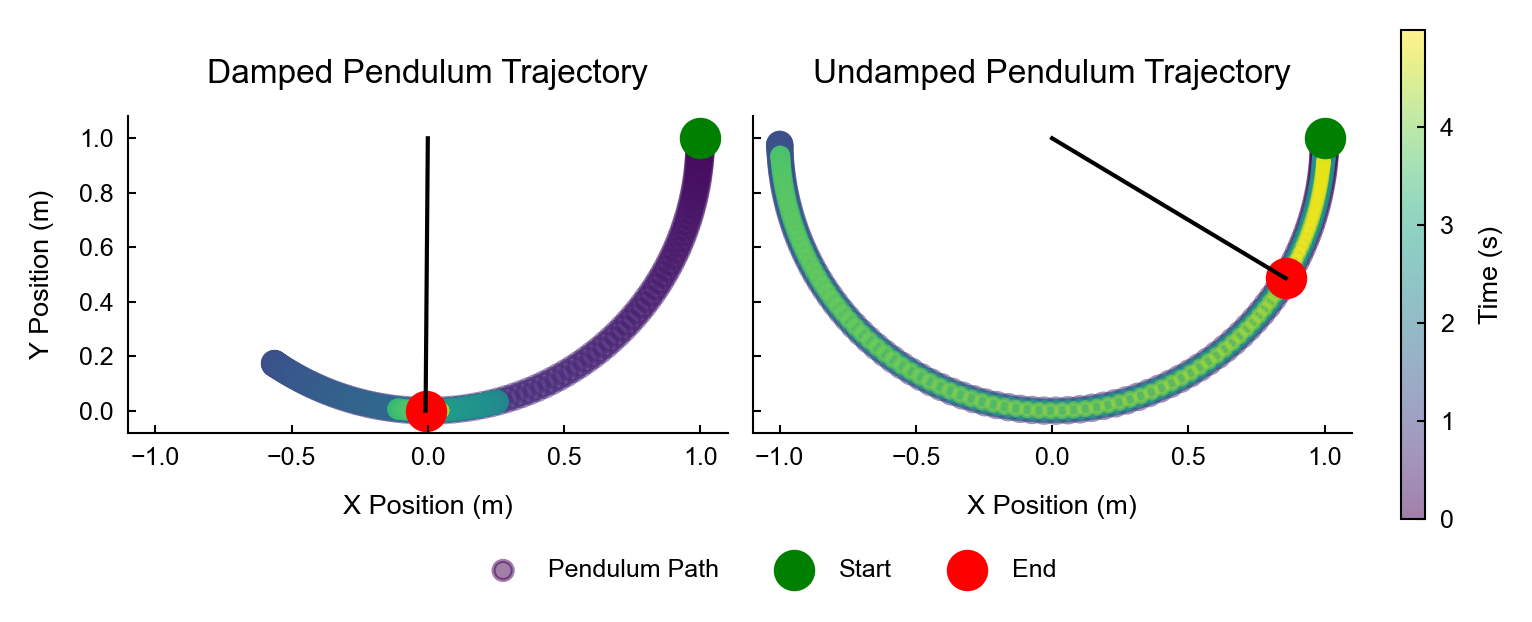

In [6]:
# Plot Pendulum Trajectory with Time Progression

import matplotlib.pyplot as plt
import numpy as np

max_size = 38
min_size = 4

# Enable constrained layout for automatic adjustment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), sharey=True, constrained_layout=True)

# Plot damped solution
theta_damped = solution_damped[:, 0].cpu().numpy()
x_damped = L * np.sin(theta_damped)
y_damped = -L * np.cos(theta_damped) + 1
colors = t.cpu().numpy()

plot_every = 20
# scatter1 = ax1.scatter(
#     x_damped[::plot_every],
#     y_damped[::plot_every],
#     c=colors[::plot_every],
#     cmap='viridis',
#     s=38,
#     label='Pendulum Path',
#     alpha=0.5
# )

# Create a size array that decreases from 38 to 18
num_points = len(x_damped[::plot_every])
sizes = np.linspace(max_size, min_size, num_points)
scatter1 = ax1.scatter(
    x_damped[::plot_every],
    y_damped[::plot_every],
    c=colors[::plot_every],
    cmap='viridis',
    s=sizes,  # Apply the decreasing sizes
    label='Pendulum Path',
    alpha=0.5
)

ax1.scatter(x_damped[0], y_damped[0], color='green', label='Start', s=80)
ax1.scatter(x_damped[-1], y_damped[-1], color='red', label='End', s=80)
ax1.plot([0, x_damped[-1]], [1, y_damped[-1]], 'k-', lw=1)
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_title('Damped Pendulum Trajectory')
# ax1.set_ylim([0, 1])

# Plot undamped solution
theta_undamped = solution_undamped[:, 0].cpu().numpy()
x_undamped = L * np.sin(theta_undamped)
y_undamped = -L * np.cos(theta_undamped) + 1

# scatter2 = ax2.scatter(
#     x_undamped[::plot_every],
#     y_undamped[::plot_every],
#     c=colors[::plot_every],
#     cmap='viridis',
#     s=38,
#     label='Pendulum Path',
#     alpha=0.5
# )

num_points = len(x_damped[::plot_every])
sizes = np.linspace(max_size, min_size, num_points)
scatter2 = ax2.scatter(
    x_undamped[::plot_every],
    y_undamped[::plot_every],
    c=colors[::plot_every],
    cmap='viridis',
    s=sizes,  # Apply the decreasing sizes
    label='Pendulum Path',
    alpha=0.5
)

ax2.scatter(x_undamped[0], y_undamped[0], color='green', label='Start', s=80)
ax2.scatter(x_undamped[-1], y_undamped[-1], color='red', label='End', s=80)
ax2.plot([0, x_undamped[-1]], [1, y_undamped[-1]], 'k-', lw=1)
ax2.set_xlabel('X Position (m)')
ax2.set_title('Undamped Pendulum Trajectory')

# Create a single legend below both plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Calculate combined limits
all_x = np.concatenate([x_damped, x_undamped])
all_y = np.concatenate([y_damped, y_undamped])

x_min, x_max = all_x.min(), all_x.max()
y_min, y_max = all_y.min(), all_y.max()

# Add padding
padding_x = (x_max - x_min) * 0.05
padding_y = (y_max - y_min) * 0.08

x_min -= padding_x
x_max += padding_x
y_min -= padding_y
y_max += padding_y
# ymax = 1

# Set the same limits and aspect ratio for both axes
for ax in [ax1, ax2]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')

# Add a single colorbar for both scatter plots, aligned with the plots' height
cbar = fig.colorbar(
    scatter2,
    ax=[ax1, ax2],
    orientation='vertical',
    fraction=0.02,
    pad=0.04
)
cbar.set_label('Time (s)')

plt.show()

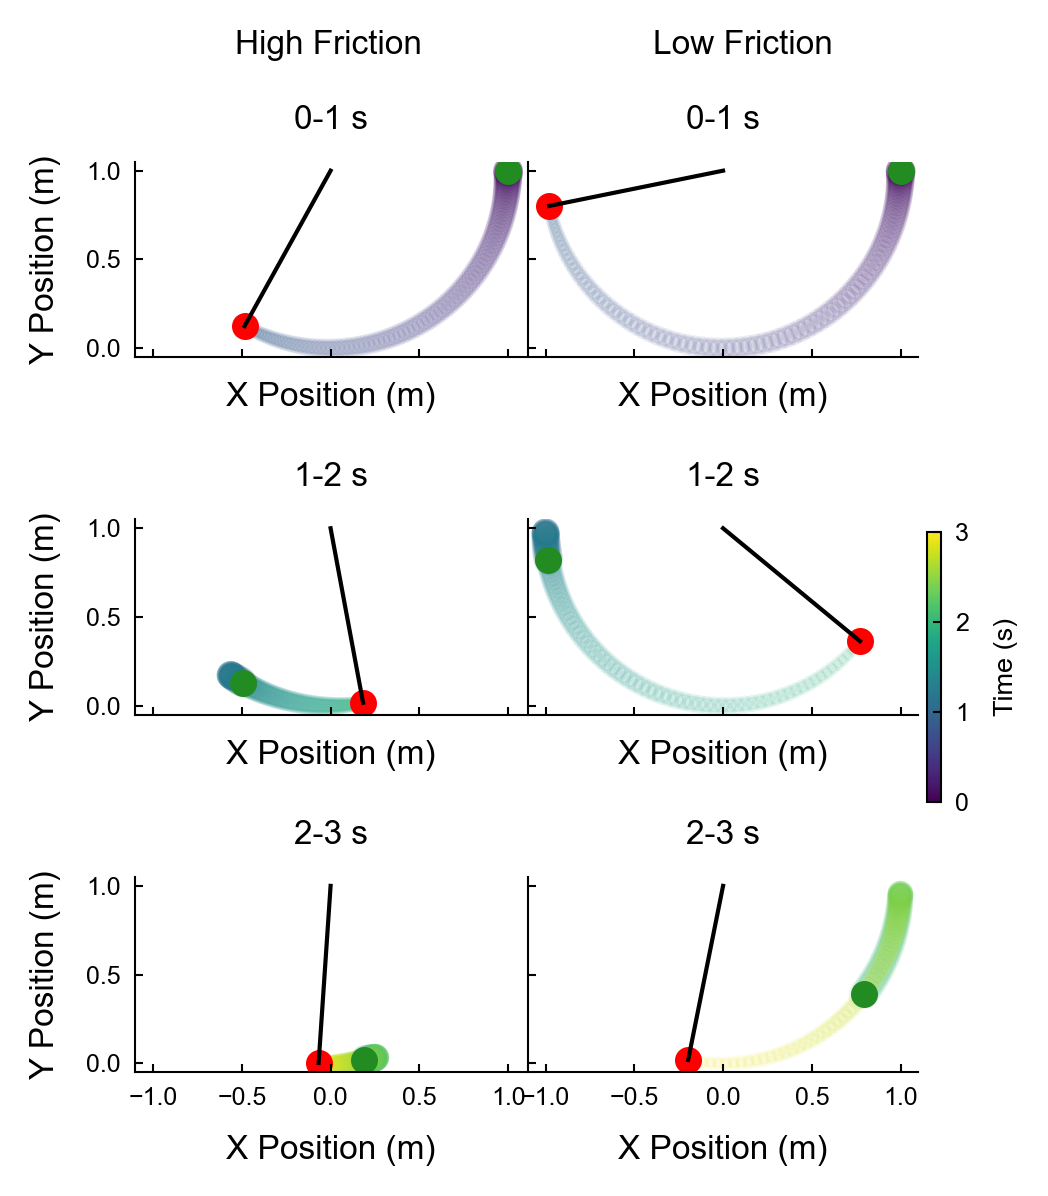

In [7]:
import matplotlib.pyplot as plt
import numpy as np

max_size = 38
min_size = 4

duration = 1.0  # seconds (each row covers 1 sec)
num_subplots = 3  # 3 rows

# Create a 3x2 grid. We use a slightly larger figure to avoid clipping text,
# but then use plt.subplots_adjust to force nearly zero whitespace.
fig, axes = plt.subplots(num_subplots, 2, figsize=(3,6), sharex=True, sharey=True)
# Tightly pack subplots: nearly-zero left/right/top/bottom margins and spacings.
fig.subplots_adjust(left=0.005, right=0.875, top=0.6, bottom=0.005, wspace=0.005, hspace=0.005)

# Add overall column titles (positioned with fig.text) as close to the plot area as possible.
fig.text(0.22, 0.62, 'High Friction', ha='center', va='center', fontsize=8)
fig.text(0.68, 0.62, 'Low Friction', ha='center', va='center', fontsize=8)

# Create a dedicated colorbar axes with minimal padding.
cbar_ax = fig.add_axes([0.885, 0.2, 0.015, 0.15])
norm = plt.Normalize(0, 3)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Loop over each time block (row).
for i in range(num_subplots):
    current_start = i * duration
    current_end = (i + 1) * duration

    # Create a mask for the current time window.
    mask = (t >= current_start) & (t < current_end)
    
    # --- Damped trajectory (left column) ---
    theta_damped = solution_damped[:, 0].cpu().numpy()[mask]
    x_damped = L * np.sin(theta_damped)
    y_damped = -L * np.cos(theta_damped) + 1
    colors_damped = t.cpu().numpy()[mask]
    
    plot_every = 20
    x_damped = x_damped[::plot_every]
    y_damped = y_damped[::plot_every]
    colors_damped = colors_damped[::plot_every]
    
    ax_damped = axes[i, 0]
    ax_damped.scatter(
        x_damped, y_damped,
        c=colors_damped,
        cmap='viridis',
        vmin=0, vmax=3,
        s=np.linspace(max_size, min_size, len(x_damped)),
        alpha=0.1
    )
    ax_damped.scatter(
        x_damped[0], y_damped[0],
        # color=sm.to_rgba(colors_damped[0]),
        color='forestgreen',
        s=30
    )
    ax_damped.scatter(
        x_damped[-1], y_damped[-1],
        # color=sm.to_rgba(colors_damped[-1]),
        color='red',
        s=30
    )
    ax_damped.plot([0, x_damped[-1]], [1, y_damped[-1]], 'k-', lw=1)
    ax_damped.set_title(f'{current_start:.0f}-{current_end:.0f} s', fontsize=8)
    ax_damped.set_xlabel('X Position (m)', fontsize=8)
    ax_damped.set_ylabel('Y Position (m)', fontsize=8)
    ax_damped.set_aspect('equal')
    ax_damped.tick_params(labelsize=6)
    
    # --- Undamped trajectory (right column) ---
    theta_undamped = solution_undamped[:, 0].cpu().numpy()[mask]
    x_undamped = L * np.sin(theta_undamped)
    y_undamped = -L * np.cos(theta_undamped) + 1
    colors_undamped = t.cpu().numpy()[mask]

    x_undamped = x_undamped[::plot_every]
    y_undamped = y_undamped[::plot_every]
    colors_undamped = colors_undamped[::plot_every]
    
    ax_undamped = axes[i, 1]
    ax_undamped.scatter(
        x_undamped, y_undamped,
        c=colors_undamped,
        cmap='viridis',
        vmin=0, vmax=3,
        s=np.linspace(max_size, min_size, len(x_undamped)),
        alpha=0.1
    )
    ax_undamped.scatter(
        x_undamped[0], y_undamped[0],
        # color=sm.to_rgba(colors_undamped[0]),
        color='forestgreen',
        s=30
    )
    ax_undamped.scatter(
        x_undamped[-1], y_undamped[-1],
        # color=sm.to_rgba(colors_undamped[-1]),
        color='red',
        s=30
    )
    ax_undamped.plot([0, x_undamped[-1]], [1, y_undamped[-1]], 'k-', lw=1)
    ax_undamped.set_title(f'{current_start:.0f}-{current_end:.0f} s', fontsize=8)
    ax_undamped.set_xlabel('X Position (m)', fontsize=8)
    ax_undamped.set_aspect('equal')
    ax_undamped.tick_params(labelsize=6)

# Add the colorbar to the dedicated axes with no extra padding.
fig.colorbar(sm, cax=cbar_ax, label='Time (s)', pad=0)
plt.savefig(os.path.join(img_save_dir, 'pendulum-swing.pdf'))
plt.show()

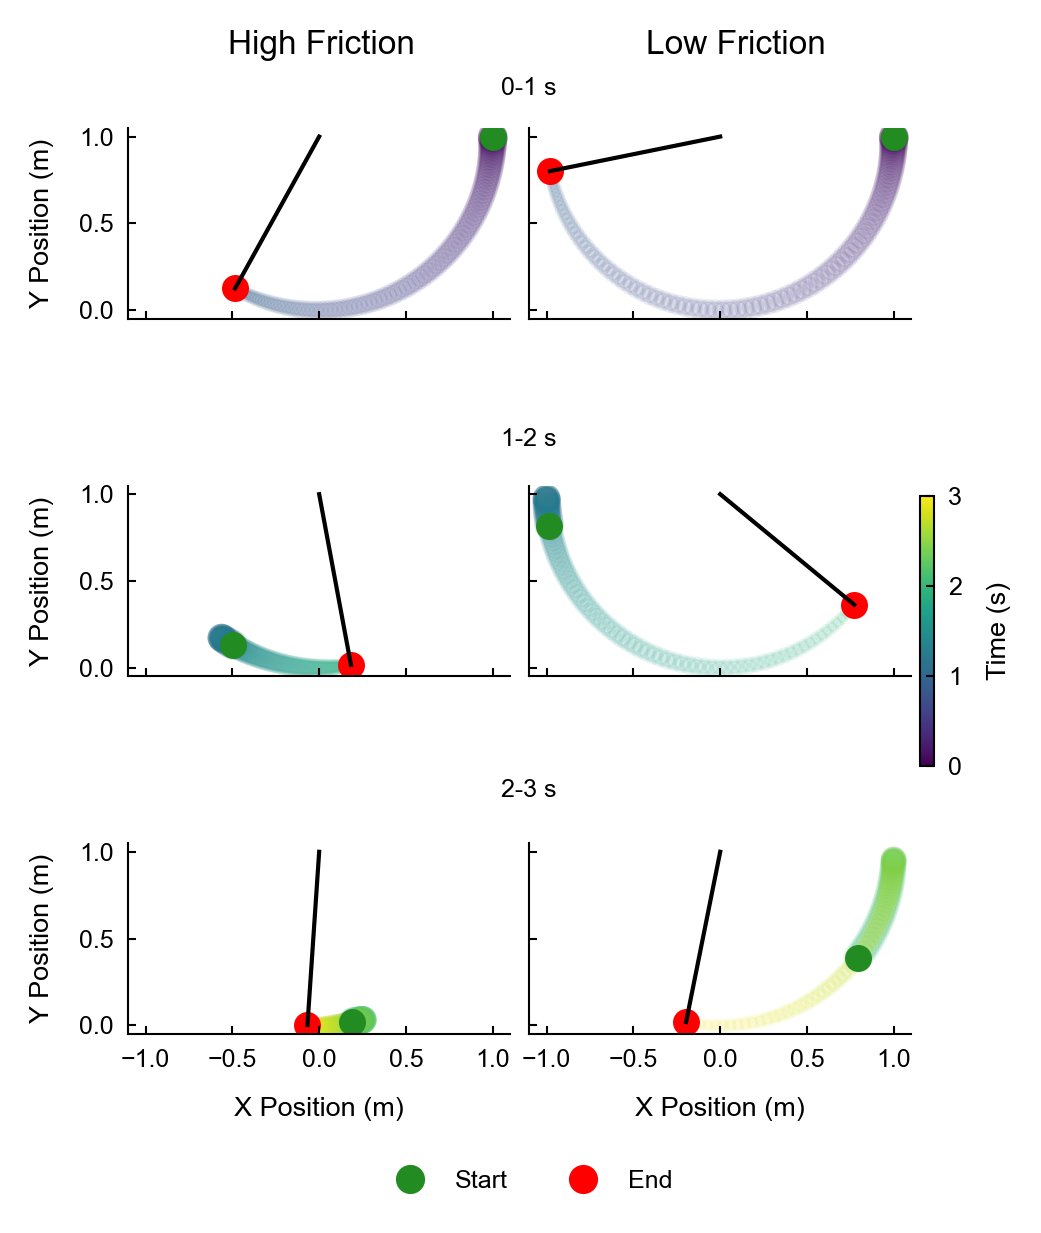

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# max_size = 38
# min_size = 4

# duration = 1.0  # seconds (each row covers 1 sec)
# num_subplots = 3  # 3 rows

# # Create a 3x2 grid. We use a slightly larger figure to avoid clipping text,
# # but then use plt.subplots_adjust to force nearly zero whitespace.
# fig, axes = plt.subplots(num_subplots, 2, figsize=(3,6), sharex=True, sharey=True)
# # Tightly pack subplots: nearly-zero left/right/top/bottom margins and spacings.
# fig.subplots_adjust(left=0.005, right=0.875, top=0.6, bottom=0.005, wspace=0.05, hspace=0.005)

# # Add overall column titles (positioned with fig.text) as close to the plot area as possible.
# fig.text(0.22, 0.6, 'High Friction', ha='center', va='center', fontsize=8)
# fig.text(0.68, 0.6, 'Low Friction', ha='center', va='center', fontsize=8)

# # Create a dedicated colorbar axes with minimal padding.
# cbar_ax = fig.add_axes([0.885, 0.2, 0.015, 0.15])
# norm = plt.Normalize(0, 3)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])

# # Loop over each time block (row).
# for i in range(num_subplots):
#     current_start = i * duration
#     current_end = (i + 1) * duration

#     # Add centered time label above each pair of subplots
#     fig.text(0.45, 0.57 - i*0.195, f'{current_start:.0f}-{current_end:.0f} s', 
#              ha='center', va='bottom')

#     # Create a mask for the current time window.
#     mask = (t >= current_start) & (t < current_end)
    
#     # --- Damped trajectory (left column) ---
#     theta_damped = solution_damped[:, 0].cpu().numpy()[mask]
#     x_damped = L * np.sin(theta_damped)
#     y_damped = -L * np.cos(theta_damped) + 1
#     colors_damped = t.cpu().numpy()[mask]

#     plot_every = 20
#     x_damped = x_damped[::plot_every]
#     y_damped = y_damped[::plot_every]
#     colors_damped = colors_damped[::plot_every]
    
#     ax_damped = axes[i, 0]
#     ax_damped.scatter(
#         x_damped, y_damped,
#         c=colors_damped,
#         cmap='viridis',
#         vmin=0, vmax=3,
#         s=np.linspace(max_size, min_size, len(x_damped)),
#         alpha=0.1
#     )
#     ax_damped.scatter(
#         x_damped[0], y_damped[0],
#         color='forestgreen',  # Start marker
#         s=30
#     )
#     ax_damped.scatter(
#         x_damped[-1], y_damped[-1],
#         color='red',  # End marker
#         s=30
#     )
#     ax_damped.plot([0, x_damped[-1]], [1, y_damped[-1]], 'k-', lw=1)
#     if i == 2:
#         ax_damped.set_xlabel('X Position (m)')
#     ax_damped.set_ylabel('Y Position (m)')
#     ax_damped.set_aspect('equal')
#     ax_damped.tick_params(labelsize=6)
    
#     # --- Undamped trajectory (right column) ---
#     theta_undamped = solution_undamped[:, 0].cpu().numpy()[mask]
#     x_undamped = L * np.sin(theta_undamped)
#     y_undamped = -L * np.cos(theta_undamped) + 1
#     colors_undamped = t.cpu().numpy()[mask]

#     x_undamped = x_undamped[::plot_every]
#     y_undamped = y_undamped[::plot_every]
#     colors_undamped = colors_undamped[::plot_every]
    
#     ax_undamped = axes[i, 1]
#     ax_undamped.scatter(
#         x_undamped, y_undamped,
#         c=colors_undamped,
#         cmap='viridis',
#         vmin=0, vmax=3,
#         s=np.linspace(max_size, min_size, len(x_undamped)),
#         alpha=0.1
#     )
#     ax_undamped.scatter(
#         x_undamped[0], y_undamped[0],
#         color='forestgreen',  # Start marker
#         s=30
#     )
#     ax_undamped.scatter(
#         x_undamped[-1], y_undamped[-1],
#         color='red',  # End marker
#         s=30
#     )
#     ax_undamped.plot([0, x_undamped[-1]], [1, y_undamped[-1]], 'k-', lw=1)
#     if i == 2:
#         ax_undamped.set_xlabel('X Position (m)')
#     ax_undamped.set_aspect('equal')
#     ax_undamped.tick_params(labelsize=6)

# # Add the colorbar to the dedicated axes with no extra padding.
# fig.colorbar(sm, cax=cbar_ax, label='Time (s)', pad=0)

# # === Add Overall Legend for Start and End Markers ===
# from matplotlib.lines import Line2D

# # Create legend markers: forestgreen for Start, red for End.
# start_marker = Line2D([], [], marker='o', color='w',
#                       markerfacecolor='forestgreen', markersize=8, label='Start')
# end_marker = Line2D([], [], marker='o', color='w',
#                     markerfacecolor='red', markersize=8, label='End')

# # Center the legend under all the subplots.
# fig.legend(handles=[start_marker, end_marker], loc='lower center', ncol=2,
#            bbox_to_anchor=(0.45, -0.05), frameon=False)
# plt.savefig(os.path.join(img_save_dir, 'pendulum-swing.pdf'))
# plt.show()